In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import networkx as nx
import os
import pickle
from typing import List
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

from common_utils.stg_utils import load_pickle
from common_utils.process import graph_to_feature_vector, adj_to_normalized_tensor
from anomaly_generation.graph_corruption import Corruptor
from embedding_training.transformer_classifier import MyNet

TRAINING_GRAPH_FOLDER = "../data/training_graphs/"
VIDEO_PARAMS_FOLDER = "../data/video_parameters/"
TESTING_GRAPH_FOLDER = "../data/testing_graphs/"
LABELS_FOLDER = "../data/testing_labels/"

TRAINING_PICKLE = "../data/torch_datasets/train_dataset_{}fpv_noadoc.pt"
MODEL_PICKLE = "../data/models/model_trained_on_{}fpv_noadoc.pt"

/opt/homebrew/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [60]:
ANOMALY_LABEL = 1.
NORMAL_LABEL = 0.
NUM_NODE_FEATURES = 85
FRAMES_PER_VIDEOCLIP = 250
BATCH_SIZE = 1

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
DEVICE

device(type='cpu')

In [44]:
class GraphDataset(Dataset):
    def __init__(self, videos_folder: str, videoparams_folder: str = None, labels_folder: str = None, frames_per_videoclip: int = None):
        assert (videoparams_folder is None) ^ (labels_folder is None), \
            "You need to specify either the folder for videoparams (to corrupt graphs) for the training set \
                or for the labels for the testing set"

        self.frames_per_videoclip = frames_per_videoclip #to cut the video in videoclips
        self.tensored_videoclips = list()
        self.labels = list()

        if videoparams_folder is not None:
            self.__load_data_train(videos_folder, videoparams_folder)
        else:
            self.__load_data_test(videos_folder, labels_folder)

    def __len__(self):
        return len(self.tensored_videoclips)

    def __getitem__(self, idx):
        # returning features, adjacency for each frame in the videoclip and the videoclip label
        return self.tensored_videoclips[idx], self.labels[idx]
    
    
    def __load_data_train(self, training_folder: str, videoparams_folder: str) -> None: 
        for dataset_path in [file for file in os.listdir(training_folder)]:
            with open(os.path.join(training_folder, dataset_path), 'rb') as f:
                try:
                    dataset = pickle.load(f)
                except:
                    print(f"[Skipped] {dataset_path}")
                    continue
            print(dataset_path)
            
            # video params
            dataset_name = dataset_path.split("_")[0]
            videoparams_path = os.path.join(videoparams_folder, dataset_name + "_video_params.pickle")
            video2params = load_pickle(videoparams_path)
            
            # for each video in the dataset
            for videoname, graphs in dataset.items():
                video_width, video_height = video2params[videoname]["width"], video2params[videoname]["height"]

                # divide the video in videoclips if specified (many videoclips per videoname), otherwise one video per videoname
                if self.frames_per_videoclip and len(graphs) > self.frames_per_videoclip:
                    graph_seqs = [graphs[x:x+self.frames_per_videoclip] for x in range(0, len(graphs), self.frames_per_videoclip)]
                else:
                    graph_seqs = [graphs]
                
                # each videoclip in pytorch
                for graph_seq in graph_seqs:                
                    self.__process_and_corrupt_videoclip(graph_seq, video_width, video_height)
    
    def __process_and_corrupt_videoclip(self, graph_seq: List[nx.Graph], width: int, height: int) -> None:
        # NORMAL GRAPHS FOR CURRENT VIDEO
        features_and_adjs = self.__graph_seq_to_features_and_adjs(graph_seq)
        self.tensored_videoclips.append(features_and_adjs)
        self.labels.append(torch.tensor(NORMAL_LABEL))
        
        # CORRUPTED GRAPHS FOR CURRENT VIDEO
        corruptor = Corruptor(frame_width=width, frame_height=height)
        corrupted_graph_seq = [corruptor.corrupt_graph(graph) for graph in graph_seq]

        corr_features_and_adjs = self.__graph_seq_to_features_and_adjs(corrupted_graph_seq)
        self.tensored_videoclips.append(corr_features_and_adjs)
        self.labels.append(torch.tensor(ANOMALY_LABEL))
    
    def __graph_seq_to_features_and_adjs(self, graph_seq: List[nx.Graph]) -> List[torch.Tensor]:
        #TODO currently, a starting empty token is added to each sequence
        features_and_adjs = [self.__get_empty_token()] + [self.__tensorize(graph) for graph in graph_seq]
        # padding
        while len(features_and_adjs) != self.frames_per_videoclip + 1: # +1 because of the starting token
            features_and_adjs.append(self.__get_empty_token())
        
        return features_and_adjs
                
    def __tensorize(self, graph: nx.Graph): # -> tuple(torch.Tensor):
        if len(graph.nodes)==0:
            return self.__get_empty_token()
        features = graph_to_feature_vector(graph)
        adj = adj_to_normalized_tensor(nx.adjacency_matrix(graph))
        return features, adj
    
    def __get_empty_token(self): # -> tuple(torch.Tensor):
        num_nodes = 20 #TODO this number in normal/abnormal graphs change everytime, see if defining a constant one is fine (should I put 1?)
        empty_features = torch.zeros(num_nodes, NUM_NODE_FEATURES)
        empty_adj = torch.zeros(num_nodes, num_nodes)
        return empty_features, empty_adj


    def __load_data_test(self, test_folder: str, labels_folder: str):
        for dataset_path in [file for file in os.listdir(test_folder)]:
            with open(os.path.join(test_folder, dataset_path), 'rb') as f:
                try:
                    dataset = pickle.load(f)
                except:
                    print(f"[Skipped] {dataset_path}")
                    continue
            print(dataset_path)
            
            # labels
            dataset_name = dataset_path.split("_")[0]
            labels_path = os.path.join(labels_folder, dataset_name + "_testing_labels.pickle")
            videoname_to_labels = load_pickle(labels_path)
            
            # for each video in the dataset
            for videoname, graphs in dataset.items():
                frame_labels = videoname_to_labels[videoname]

                # divide the video in videoclips if specified (many videoclips per videoname), otherwise one video per videoname
                if self.frames_per_videoclip and len(graphs) > self.frames_per_videoclip:
                    graph_seqs = [graphs[x:x+self.frames_per_videoclip] for x in range(0, len(graphs), self.frames_per_videoclip)]
                    labels = [self.__frame_labels_to_videoclip_label(frame_labels[x:x+self.frames_per_videoclip]) \
                        for x in range(0, len(frame_labels), self.frames_per_videoclip)]
                else:
                    graph_seqs = [graphs]
                    labels = [self.__frame_labels_to_videoclip_label(frame_labels)]
                
                # each videoclip in pytorch
                for graph_seq, label in zip(graph_seqs, labels):                
                    self.__process_videoclip(graph_seq, label)
    
    def __frame_labels_to_videoclip_label(self, frame_labels: List[int]) -> int:
        ''' Here the rule on how to label a video as anomaly according to the frame labels'''
        #TODO for the moment, if there is at least one anomalous frame, the whole videoclip is considered anomalous
        if sum(frame_labels) > 0:
            return ANOMALY_LABEL
        return NORMAL_LABEL
    
    def __process_videoclip(self, graph_seq, label) -> None:
        features_and_adjs = self.__graph_seq_to_features_and_adjs(graph_seq)
        self.tensored_videoclips.append(features_and_adjs)
        self.labels.append(torch.tensor(label))




In [ ]:
''' CREATING THE TRAINING SET '''
train_set = GraphDataset(videos_folder=TRAINING_GRAPH_FOLDER, videoparams_folder=VIDEO_PARAMS_FOLDER, frames_per_videoclip=FRAMES_PER_VIDEOCLIP)
print(f"Number of clips: {len(train_set)}")
torch.save(train_set, TRAINING_PICKLE.format(FRAMES_PER_VIDEOCLIP))

train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
for el in [10, 50, 250, 500]:
    print(f"Generating data with {el} frames per videoclip")
    train_set = GraphDataset(videos_folder=TRAINING_GRAPH_FOLDER, videoparams_folder=VIDEO_PARAMS_FOLDER, frames_per_videoclip=el)
    print(f"Number of clips: {len(train_set)}")
    torch.save(train_set, TRAINING_PICKLE.format(el))
    print("\n")

In [61]:
''' LOADING THE TRAINING SET '''
train_set = torch.load(TRAINING_PICKLE.format(FRAMES_PER_VIDEOCLIP))
print(f"Number of clips: {len(train_set)}")

KeyboardInterrupt: 

In [ ]:
def collate_fn_multi(batch):
    seq_features_and_adjs = [[(features.to(DEVICE), adj.to(DEVICE)) for features, adj in item[0]] for item in batch]
    label = [item[1].to(DEVICE) for item in batch]
    #seq_features_and_adjs = [item[0] for item in batch]
    #label = [item[1] for item in batch]
    return [seq_features_and_adjs, label]


train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)#, collate_fn=collate_fn) #TODO fix batching problem
# this collate function works but the problem is when I need to encode one frame at a time (How to do that?)

In [69]:
''' CREATING THE TEST SET '''
test_set = GraphDataset(videos_folder=TESTING_GRAPH_FOLDER, labels_folder=LABELS_FOLDER, frames_per_videoclip=FRAMES_PER_VIDEOCLIP)
print(f"Number of clips: {len(test_set)}, with {len([l for _, l in test_set if l.item()==0.])} normal videos \
    and {len([l for _, l in test_set if l.item()==1.])} real anomalies")

[Skipped] .DS_Store
ShanghaiTechDataset_testing.pickle
Number of clips: 133, with 30 normal videos     and 103 real anomalies


# TRAINING

In [ ]:
epochs = 200
model = MyNet(
    features_size=NUM_NODE_FEATURES,
    embedding_size=8, #value for embedding vector (MUST BE EVEN and dividible by nhead)
    max_length=FRAMES_PER_VIDEOCLIP + 1 # because of the starting token
).to(DEVICE)

criterion = nn.BCELoss()
lr = 0.0001
optimizer = torch.optim.Adam(
    (p for p in model.parameters() if p.requires_grad), lr=lr
)
model.train()

print("starting training")
epoch_to_loss_acc = dict()
max_accuracy = 0
for epoch in range(epochs):
    epoch_loss = 0
    epoch_correct = 0
    epoch_count = 0
    for batch in iter(train_dataloader):
        # to device
        seq_features_and_adjs, label = batch #len(seq) = FRAMES_PER_VIDEOCLIP + 1 (if no batches)
        seq_features_and_adjs = [(features.to(DEVICE), adj.to(DEVICE)) for features, adj in seq_features_and_adjs]
        label = label.to(DEVICE)

        prediction = model.forward(seq_features_and_adjs)

        # loss and step
        prediction = prediction.squeeze(1)
        loss = criterion(prediction, label)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5) # TODO
        optimizer.step()

        # accuracy and loss computation
        prediction = torch.round(prediction) #0 or 1 
        correct = (prediction == label).sum()

        epoch_correct += correct
        epoch_count += label.size(0)
        epoch_loss += loss.item()

    epoch_accuracy = (epoch_correct / epoch_count).item()
    print(f"{epoch=} -> {epoch_loss=} - {epoch_accuracy=}")
    epoch_to_loss_acc[epoch] = [epoch_loss, epoch_accuracy]

    if epoch_accuracy > max_accuracy:
        max_accuracy = epoch_accuracy
        torch.save(model.state_dict(), MODEL_PICKLE.format(FRAMES_PER_VIDEOCLIP))

In [49]:
metrics_df = pd.DataFrame(epoch_to_loss_acc).transpose().reset_index().rename(columns={"index": "Epoch", 0: "Loss", 1: "Accuracy"})
metrics_df

,Epoch,Loss,Accuracy
0,0,81862.707572,0.607774
1,1,105010.036609,0.628277
2,2,116524.526451,0.633259
3,3,123522.617307,0.641696
4,4,125012.515581,0.645137
5,5,120319.806018,0.655287
6,6,117104.387770,0.674855
7,7,115658.640709,0.686173
8,8,113501.935853,0.694642
9,9,112287.967458,0.694922


<AxesSubplot: xlabel='Epoch'>

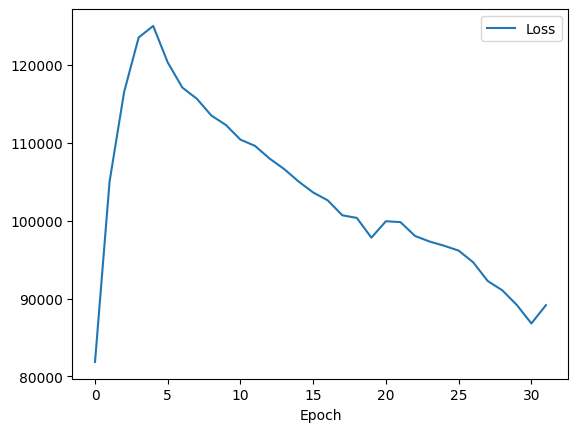

In [50]:
metrics_df.plot(x="Epoch", y="Loss")

<AxesSubplot: xlabel='Epoch'>

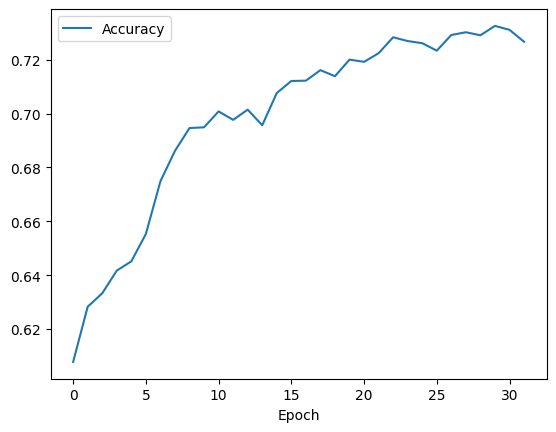

In [51]:
metrics_df.plot(x="Epoch", y="Accuracy")

# TESTING

In [70]:
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)#, collate_fn=collate_fn) #TODO fix batching problem

load_best_one = True

if load_best_one:
    model = MyNet(
        features_size=NUM_NODE_FEATURES,
        embedding_size=8, #TODO decide a value for embedding vector (MUST BE EVEN and dividible by nhead) a low number is probably enough since most of the features are one-hot encoded ones
        max_length=FRAMES_PER_VIDEOCLIP + 1 #TODO because of the starting token
    ).to(DEVICE)
    model.load_state_dict(torch.load(MODEL_PICKLE.format(FRAMES_PER_VIDEOCLIP)))
model.eval()

correct_preds = 0
total_preds = 0
tp, fp, tn, fn = 0, 0, 0, 0

with torch.no_grad():
    for batch in iter(test_dataloader):
        # to device
        seq_features_and_adjs, label = batch
        seq_features_and_adjs = [(features.to(DEVICE), adj.to(DEVICE)) for features, adj in seq_features_and_adjs]
        label = label.to(DEVICE)

        prediction = model.forward(seq_features_and_adjs)

        # accuracy computation
        prediction = torch.round(prediction) #0 or 1 
        correct = (prediction == label).sum()
        tp += (prediction == label == ANOMALY_LABEL).sum().item()
        fp += (prediction == ANOMALY_LABEL != label).sum().item()
        tn += (prediction == label == NORMAL_LABEL).sum().item()
        fn += (prediction == NORMAL_LABEL != label).sum().item()

        correct_preds += correct
        total_preds += label.size(0)


print(f"Testing results: accuracy={correct_preds / total_preds}")
print(f"{tp=}, {fp=}, {tn=}, {fn=}")
accuracy = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall = tp/(tp+fn)
print(f"{accuracy=}")
print(f"{precision=}")
print(f"{recall=}")

datasets = "-".join([dataset.split("_")[0].strip("Dataset") for dataset in os.listdir(TESTING_GRAPH_FOLDER) if not dataset.startswith(".")])
print(datasets)
with open("results.csv", "a+") as csv:
    csv.write(f"{FRAMES_PER_VIDEOCLIP},{tp},{fp},{tn},{fn},{accuracy},{precision},{recall},{datasets}\n")


Testing results: accuracy=0.37593984603881836
tp=25, fp=5, tn=25, fn=78
accuracy=0.37593984962406013
precision=0.8333333333333334
recall=0.24271844660194175
ShanghaiTech
